# Text Data Cleanup with XLM-R Embeddings and UMAP Visualisation

> Identify noisy text to remove from a Machine Translation dataset by visualising text embeddings with UMAP

badges: true
categories: nlp, visualization, bokeh, clustering

In order for Machine Translation to be useful in the real world, we should should strive to train it on high quality translation data. This is doubly true for lower-resource languages such as Irish, where clean training data is relatively limited. In this article we will try and identify and remove clusters of dirty/noisey samples in our parallalel dataset. The stages we will go through are:

- **Generate** embeddings from a pre-trained multi-lingual model, XLM-RoBERTa
- **Visualise** these embeddings using a dimensionality technique via UMAP
- **Identify** clusters in a sample of the data that seem to be of low translation quality via Bokeh
- **Remove** similar samples from the main dataset via nmslib

## Dimension Reduction - UMAP
- Dimensionality reduction techniques attempt to find the latent features in your data

- [Uniform Manifold Approximation and Projection (UMAP)](https://umap-learn.readthedocs.io/en/latest/index.html) is a dimension reduction technique published in [2018 by McInnes and Healy](https://arxiv.org/abs/1802.03426) that can be used for visualisation of high dimensional data, similarly to [[t-SNE]]. 

- Its main advantage is that it is fast (faster than t-SNE when dealing with large datasets) and also better maintains the global structure of the data. 

- [Pair Code has an excellent explanation complete with visualisations of UMAP](https://pair-code.github.io/understanding-umap/#:~:text=In%20the%20simplest%20sense%2C%20UMAP,behind%20them%20is%20remarkably%20simple) if you'd like to learn more and docs also have excellent [interactive visualisation examples from users](https://umap-learn.readthedocs.io/en/latest/interactive_viz.html)

- It also has [beautifully well-written](https://umap-learn.readthedocs.io/en/latest/index.html) documentation 

- McInnes gives a useful overview of UMAP here at the SciPy 2018 conference:
> youtube: https://www.youtube.com/watch?v=nq6iPZVUxZU

## Similarity Search - nmslib
- [nmslib](https://github.com/nmslib/nmslib/blob/master/python_bindings/notebooks/search_sparse_cosine.ipynb) is an "__efficient similarity search library and a toolkit for evaluation of k-NN methods for generic non-metric spaces__" and is easily installed with ```pip install nmslib```
    
- In testing [Ben Frederickson found](http://www.benfrederickson.com/approximate-nearest-neighbours-for-recommender-systems/) that between nmslib, [FAISS](https://engineering.fb.com/ml-applications/faiss-a-library-for-efficient-similarity-search/) (Facebook) and [annoy](https://github.com/spotify/annoy) (Spotify) nmslib was the fastest nearest neighbours library for CPU. Note FAISS on GPU is blazes past nmslib and annoy, but can also difficult to set up.

- [Milvus](https://github.com/milvus-io/milvus) is an interesting library that was open sourced in late 2019 which offers similarity search using FAISS, nmslib or annoy as well as GPU capability. If I had had more time I would have explored this further

-  ElasticSearch [post](https://www.elastic.co/blog/text-similarity-search-with-vectors-in-elasticsearch) and [article](https://medium.com/analytics-vidhya/elasticbert-information-retrieval-using-bert-and-elasticsearch-51fef465b9ae) is yet another tool we could use to carry out the similarity search between our text embeddings.

- Finally,  [DAIR.ai](www.dair.ai) recently posted a video called ["101 Ways to Solve Search"](https://www.youtube.com/watch?v=VHm6_uC4vxM) by [Pratik Bhavsar](www.pratik.ai) which is a great introduction to how search works in general. Also [models.pratik.ai](models.pratik.ai) is a really great flow chart visualisation which he tries to keep up to date of the models and techniques available for semantic search and NLP in general

> youtube: https://www.youtube.com/watch?v=VHm6_uC4vxM

- BONUS: [@hmendonca's EDA notebook on kaggle](https://www.kaggle.com/hmendonca/proper-clustering-with-facenet-embeddings-eda) is an excellent example showing how to use annoy to group and display similar images (faces in this case).

## Text Embeddings - XLM-R

We derive our text embedding by passing the text sample though [XLM-RoBERTa Large](https://arxiv.org/abs/1911.02116) and extracting the values in final hidden layer. XLM-R  is a multilingual model and should work reasonably well for both Irish and English

Research has been done on BERT to show that by concatenating the final 4 layers of the model one gets even richer contextual embeddings. In the interest of simplicity we will stick to the final layer only for the moment, although using additional layers would be an interesting area of exploration!

In [251]:
#hide
from fastai2.text.all import *
from fastai2.basics import *
from fastprogress.fastprogress import progress_bar

import seaborn as sns
from transformers import XLMRobertaModel, XLMRobertaTokenizer

from bokeh.layouts import grid
from bokeh.models import ColumnDataSource 
from bokeh.models.widgets.tables import DataTable, TableColumn
from bokeh.plotting import figure
from bokeh.io import show, output_notebook
from bokeh.palettes import d3

import umap
import umap.plot
import nmslib

from sklearn.metrics.pairwise import cosine_similarity
from datetime import date

In [2]:
today = date.today()

## Text Embeddings for Fun and Profit

Text embeddings are incredibly valuable and can also be used for things like spell checking; have a look at [@er214's post](https://blog.usejournal.com/a-simple-spell-checker-built-from-word-vectors-9f28452b6f26) and [notebook](https://github.com/er214/spellchecker) to see how they **used GloVe word embeddings to create a spell-checker** for their dataset. The [fastai forums post](https://forums.fast.ai/t/nlp-any-libraries-dictionaries-out-there-for-fixing-common-spelling-errors/16411) is also worth a read if you have time, they also created a "pretentiousness" embedding to score news outlets 🤣.

While we are using embeddings for chunks of text, as opposed to individual words, the concept is the same.



## Generate our Embeddings

#### Load Raw ParaCrawl Data
First lets load our raw data. This is data that has been crawled from the internet and contains a few different types of artifacts including:
- Non-latin scripts 
- Other random characters (e.g. '©','³','º')
- Text samples that are unlikely to have been translated to Irish by a human, including
    - Porn sites
    - Lighting sites (who knows why?)

Lets see how much we can find by turning our samples into embeddings and using dimenstionality reduction to visualise them. 

For fun, we'll label texts that contain "sex", "lighting" and cyrillic characters like "и", "з" or "л" see if they get clustered together when we visualise our word embeddings later. We will also lowercae our entire dataset; many of the legal texts here are fully written in uppercase, however right now we care more about the content of the text as opposed to the style

In [3]:
#hide_input
path = Path('data/irish/crosslang')
ga = pd.read_csv(path/'paracrawl.ga', error_bad_lines=False, sep='\n\n', header=None, engine='python')
en = pd.read_csv(path/'paracrawl.en', error_bad_lines=False, sep='\n\n', header=None, engine='python')
df=pd.concat([ga, en], axis=1)
df.columns=['ga','en']
df.reset_index(inplace=True, drop=True)

# Lowercase
df.ga = df.ga.str.lower()
df.en = df.en.str.lower()

# Label noisey samples
df['noise_type'] = 'na'
noise_dict = {'sex':'sex','lighting':'lighting','и':'cyrillic', 'л':'cyrillic', 'з':'cyrillic'}
for key in noise_dict: df.loc[df.en.str.contains(key), 'noise_type'] = noise_dict[key]

print(f'Dataset has : {len(df)} rows')
df.head(3)

Dataset has : 784606 rows


,ga,en,noise_type
0,d'fhonn go raibh maith agat litreacha grianghraif teagmhã¡il naisc,order thanks letters photos contact links,na
1,"ingus & oleg ngo ""ordãº"" go raibh maith ingus agus oleg do na fionnachtana agus aistreoidh sã© chuig an reburial na taisã de dhã¡ saighdiãºirã an airm dearg.","ingus & oleg ngo ""order"" thank ingus and oleg for the discovery and transfer to the reburial of the remains of two soldiers of the red army.",na
2,"renarsp poiblã eagraã ocht ""ordãº"" mbuã ochas lenã¡r gcomhghleacaã - ã sã¡ideoirã renarsp, a bhrath agus chun cãºnaimh i dhã saighdiãºir gearmã¡nach. saighdiãºirã a tharchur chuig an reburial an reilig na gearmã¡ine.","renarsp public organization ""order"" thanks to our colleague - users renarsp, for the detection of and assistance in the exhumation of a german soldier. soldiers referred to the reburial of the german cemetery.",na


#### Get Pre-Trained XLM-RoBERTa Model
Next we will initialise our XLM-RoBERTa model (commonly known as "XLM-R"). I chose this model as it is a multilingual model trained on 100 languages, including both English and Irish, if we choose to look at the Irish embeddings too.

Here we will embed the **English** samples as this is where a lot of the noise in the dataset seems to stem from.

We use XLM-R Large in this example, but XLM-R Base will also work well

In [4]:
model = XLMRobertaModel.from_pretrained('xlm-roberta-large')
model.cuda()

tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
pad_idx=tokenizer.pad_token_id

#### Set up Tokenizer and Padding

As part of setting up our dataloader we'll need to define our:
- Tokenizer Transform, which is a wrapper around the HuggingFace tokenizer 
- Function to add padding to each sample so that we can batch our samples
- Function to create a padding mask so that our model doesn't attend over the padding tokens

In [5]:
# hide
#Tokenizer:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): return torch.tensor((self.tokenizer.encode(x, add_special_tokens=True))) 
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

# Padding function:
def my_pad_input(samples, pad_idx=1, pad_fields=0, pad_first=False):
    max_len_l = max([len(s) for s in samples])
    def _f(x):
        pad =  x.new_zeros(max_len_l-x.shape[0])+pad_idx
        x1 = torch.cat([pad, x] if pad_first else [x, pad])
        return retain_type(x1, x)
    outp=[]
    for s in samples: outp.append(_f(s))
    return outp   

# Padding mask
def pad_mask(o):
    '0 for masked tokens, else 1'
    return (o != pad_idx)*1

#### Create our Dataloader
Now we are ready to create our dataloader so that we can quickly iterate through our samples. I'm using fastai here, however you could also use either a PyTorch or Tensorflow dataloader here, the rest of this notebook doesn't have a fastai dependency.

To start, we'll look at a random sample of 40,000 samples, about 5% of our data. Remember we are only retrieving embeddings for our English samples for now.

In [6]:
#hide
n_samples=40000
lang='en'
np.random.seed(42) 
rand_idxs = np.random.choice(len(df), n_samples, replace=False)
samp = df.loc[rand_idxs].copy()
samp.reset_index(inplace=True, drop=False)
samp.columns = ['main_index', 'ga', 'en', 'noise_type']
samp_texts = samp[lang].values
all_texts = df[lang].values
samp.head(3)

,main_index,ga,en,noise_type
0,445383,"(b) airgid dá dtagraítear i bhfo-alt (1) (b) den alt seo,","(i) in subsection (1) by deleting the definition of “dependant”, and",na
1,760662,áilleacht agus físeáin gnéas kinky,teenagers and naked yulia tymoshenko,na
2,304902,"(a) déanfar rannpháirtithe atá faoi réir a n-ainmnithe faoi airteagal xix, alt 5 (a) (i), a ainmniú i leith méideanna a bhéarfaidh le himeacht ama gur comhionann na coibhnis idir sealbháin na rannpháirtithe de chearta tarraingthe speisialta de bhreis ar a nglan-leithroinnteanna carnacha agus a sealbháin oifigiúla óir agus iomlaoide coigríche.","(a) participants subject to designation under article xix, section 5 (a) (i) shall be designated for such amounts as will promote over time equality in the ratios of the participants' holdings of special drawing rights in excess of their net cumulative allocations to their official holdings of gold and foreign exchange.",na


In [7]:
#hide
bs,sl = 256,1024

def get_dls(texts, bs=256, sl=1024, show=True):
    splits = [list(range(len(texts))),list(range(bs))]
    tls = TfmdLists(texts, TransformersTokenizer(tokenizer), splits=splits , dl_type=TfmdDL)
    dls = tls.dataloaders(bs=bs, seq_len=sl, before_batch=my_pad_input, shuffle_train=False)
    if show==True: dls.show_batch(max_n=1)
    return dls

You can see the English sample below, including the special tokens `< s >` and `< /s >` used by XLM-R to denote the start and end of the sequence. You can also see all the padding needed for this sample.

In [8]:
samp_dls = get_dls(samp_texts, bs, sl, show=True)

<s> (i) in subsection (1) by deleting the definition of “dependant”, and</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


## Get Embeddings

Now we're ready to retrieve our embeddings from the pretrained multi-lingual model. We do this by simply passing our samples to the model and saving the output activations from the last layer of the model. From this we can generate an embedding of size (40000, 1024) which we can then pass to our dimensionality reduction algorithm. 

Processing 40k samples with UMAP takes about 5 minutes. After a little testing with `n_neighbors` and `min_dist` I found the defaults work quite well although its always worth playing around with the parameters and distance metric used.

In [9]:
#hide
def get_text_embeddings(model, dls, emb_nm=None, n_files=1):
    '''
        Grab logits from model and save embedding file, optionally save across multiple files
        n_files : number of files to save the embeddings too, incase they cannot all fit in memory'
    ''' 
    with torch.no_grad():
        model.eval() 
        f_split_interval = int(len(dls.train)/n_files)+1
        new_file=False
        file_count=0
        for i, o in enumerate(progress_bar(dls.train)):
            # Extract
            mask = pad_mask(o)
            _, tmp=model(o, attention_mask=mask)  
            
            # Store
            if i == 0: 
                embs = tmp
            elif new_file:
                embs = tmp
                new_file=False
            else: 
                embs = torch.cat([embs,tmp])
            
            # Save
            if n_files>1:
                if (i > 0) & (i % (f_split_interval) == 0): 
                    torch.save(embs, emb_nm + f'_{file_count}')
                    print(f'Embedding file {file_count} saved')
                    file_count+=1
                    del embs
                    gc.collect()
                    new_file=True
                elif i == len(dls.train)-1: 
                    torch.save(embs, emb_nm + f'_{file_count}')
                    new_file=True
                    print(f'Embedding file {file_count} saved')
            elif (n_files==1) & (i == len(dls.train)-1):
                torch.save(embs, emb_nm)
                
        # RELOAD SAVED EMBEDDING FILES IF n_files>1
        if n_files>1:
            del model
            torch.cuda.empty_cache()
            gc.collect()
            for j in range(0,n_files):
                if j==0: embs = torch.load(emb_nm + f'_{int(j):.0f}')
                else:
                    tmp = torch.load(emb_nm + f'_{int(j):.0f}')
                    embs = torch.cat([embs,tmp])
            torch.save(embs, emb_nm+'_full')

        print(f'Embedding tensor(s) saved here: "{emb_nm}", full tensor size is : {embs.size()}')
    return embs

In [10]:
samp_embs = torch.load('models/xlm-r_large_embs_en_samp_2020-06-29').to('cpu')

In [10]:
#hide
samp_emb_nm = f'models/xlm-r_large_embs_en_samp_{today}'
samp_embs = get_text_embeddings(model, samp_dls, emb_nm=samp_emb_nm, n_files=1)
samp_embs=samp_embs.to('cpu')

samp_embs = torch.load('models/xlm-r_large_embs_en_samp_2020-06-29').to('cpu')

Embedding tensor(s) saved here: "models/xlm-r_large_embs_en_samp_2020-06-29", full tensor size is : torch.Size([40000, 1024])


**Scaling your Embeddings**

One thing to consider might be whether you should scale your embeddings. The embeddings used here had mean 0 and standard deviation of 0.5, normalising them to (0,1) didn't seem to have much of an impact on the UMAP visualisation so it is not done here. Scikit-Learn has a [wide variety of scaling functions](https://scikit-learn.org/stable/modules/preprocessing.html) if you do need to scale your data.

In [11]:
#hide
# std=samp_embs.std()
# m=samp_embs.mean()

# scaled_embs = (samp_embs - m)/std
# scaled_embs.mean(), scaled_embs.std()

# scaled_mapper = umap.UMAP(random_state=42).fit(scaled_embs.cpu().numpy())
# scaled_p = umap.plot.interactive(scaled_mapper, hover_data=samp, point_size=2, labels=samp.noise_type)
# output_notebook()
# show(scaled_p)

## Remove similar samples from the entire dataset
We will remove items by:

1. Visually **identifying** similar noisey embeddings

2. Taking the **average of these embeddings**

3. Calculating a **distance** between this average embedding and all of the embeddings in our entire dataset

3. Removing embeddings that are within a certain distance to the average embeddings

## Visualise: Dimensionality Reduction with UMAP

In [11]:
samp_mapper = umap.UMAP(random_state=42).fit(samp_embs.cpu().numpy())

In [12]:
#hide
output_notebook()

def plot_emb_app(doc):
    # CONSTANTS
    l = len(samp) 
    
    lang1, lang2, label_col = 'en', 'ga', 'noise_type'
    plot_width,plot_height = 525,525
    
    # DATA
    data = pd.DataFrame(samp_mapper.embedding_[:l], columns=("x", "y"))
    df = samp[[lang1,lang2,'main_index', label_col]].iloc[:l,:]
    hover_data = df[[lang1,lang2,label_col,'main_index']]
    data[label_col] = df[label_col]
    
    # SET LABELS
    labels = samp[label_col]
     
    # TOOLTIP
    tooltip_dict = {}
    for col_name in hover_data:
        data[col_name] = hover_data[col_name]
        tooltip_dict[col_name] = "@" + col_name
    tooltips = list(tooltip_dict.items())
    
    # COLOR BY LABEL
    palette = d3['Category10'][len(df[label_col].unique())]
    colormap = {x:palette[i] for i,x in enumerate(df[label_col].unique())}
    data['colors'] = [colormap[x] for x in df[label_col]]
    
    # PLOT1
    s1 = ColumnDataSource(data=data)
    p1 = figure(
        tooltips=tooltips,
        plot_width=plot_width,
        plot_height=plot_height,
        tools=['lasso_select','pan','wheel_zoom','box_zoom','reset','save'],
        active_drag="lasso_select",
        title="Select points with Lasso tool",
    )
    p1.title.vertical_align = 'top'
    
    # CREATE CIRCLE 1
    c1=p1.circle("x", "y", source=s1, alpha=0.5, color='colors', size=2)
    ds1 = c1.data_source
    
    # PLOT2
    s2 = ColumnDataSource(data=dict(x=[], y=[], idx=[]))
    p2 = figure(
        plot_width=int(plot_width/2),
        plot_height=int(plot_height/2),
        x_range=(min(data['x'])-1, max(data['x'])+1),
        y_range=(min(data['y'])-1, max(data['y'])+1),
        title="Selected Points from Main Plot",
    )
    p2.title.vertical_align = 'top'
    c2 = p2.circle("x", "y", source=s2, alpha=0.6, color="firebrick", size=3)
    ds2 = c2.data_source
    
    # SELECT CALLBACK
    def select_callback(attrname, old, new):
        global selected_indxs        
        d1 = ds1.data
        d2 = dict()
        selected_indxs = new
        xs,ys,t1,t2,idxs,lab1 = [],[],[],[],[],[]
        
        for i in range(len(selected_indxs)):
            xs.append(d1['x'][selected_indxs[i]])
            ys.append(d1['y'][selected_indxs[i]])
            lab1.append(d1[label_col][selected_indxs[i]])
            t1.append(d1[lang1][selected_indxs[i]])
            t2.append(d1[lang2][selected_indxs[i]])
        d2['x'], d2['y'], d2['idx'], d2[lang1], d2[lang2], d2[label_col] = xs, ys, selected_indxs, t1, t2, lab1
        ds2.data = d2 # BEST PRACTICE --- update .data in one step with a new dict
    
    s1.selected.on_change('indices', select_callback)

    # TABLE OF SELECTED POINTS
    columns = [
        TableColumn(field="idx", title="data idx", width=15),
        TableColumn(field=lang1, title=lang1),
        TableColumn(field=lang2, title=lang2),
        TableColumn(field=label_col, title=label_col, width=50),
        TableColumn(field="x", title="X axis", width=40),
        TableColumn(field="y", title="Y axis", width=40),
    ]
    table = DataTable(
        source=s2,
        columns=columns,
        width=900,
        height=400,
        sortable=True,
        selectable=True,
        editable=True,
    )
    
    doc.add_root(grid([p1, p2, table], ncols=2))

Loading BokehJS ...

In [13]:
#hide_input
nb_url="http://0.0.0.0:8888"    # optional, depending on where you are running the notebook 
show(plot_emb_app, notebook_url=nb_url)

## Identify clusters in a sample of the data that seem to be of low translation quality

Can we identify suspect looking clusters of data? Yes! 

- We can see the orange "islands" that we have labelled all contain text related to "lighting", "LED", "Lamps" etc, some of which are not even in English.

- The sparse cluster of green blue points and their neighbours are also full of language related to pornography

- We don't see so many Cryllic points, however this was also the least common of our labels, comprising only (0.07% of our labels)

Other "islands" that can identified by hovering over them include:
- Arabic texts
- Website footers
- Text from jewellery sites (e.g. Pandora) and also clothing sites


Below you can see some of the Arabic texts in our main dataset we have discovered:

In [284]:
#hide_input
# PULL SELECTED DATA FROM PLOT INTO DATAFRAME
fin_selected_indxs = selected_indxs
df.loc[samp.loc[fin_selected_indxs]['main_index']].head(5)

,ga,en,noise_type
572564,مــحل الإقـامة: الـ riyadh,مــحل الإقـامة: ..ايـ جنوب ــران..,na
570189,رد: درس..استخدآم content-aware scale..~,مــحل الإقـامة: طيبهـ الطيبهـ,na
567067,ملعقة طعام خل ابيض,قلعة فن البكسل ( pixels art ),na
573439,هـــذاك لـــو انـــي مـــن الـوقــت مـهــزوم,قلعة دروس الايميج ريدي,na
571181,إرسال رسالة خاصة إلى adigatalostan,إرسال رسالة خاصة إلى nimrow,na


I am fairly confident that none of the text in some these islands contain valuable translations and are likely the result of automated translations of suspect quality that we would like to remove.

## Remove similar samples from the full dataset
To remove similar samples we will calculate a distance metric between each of our selected embeddings and each of the embeddings in the full dataset. Alternativly we could also calculate the "average embedding" of all of our selected datapoints, and then calculate the distance between this average and each of the embeddings in the main dataset. 

From experimentation I found that the first option is more effective at identifying more of the noisy data we are looking for. In addtion, because our nms algorithm is super fast at retrieval there isn't any significant overhead to this approach over using the average embedding.

First of all, we'll need to generate embeddings for all of our 780k text samples. This might take a little while depending on the size of your dataset so kick off the extraction and grab a coffee.

In [182]:
#hide 
# CALCULATE AVERAGE OF SELECTED EMBEDDINGS
def calc_avg_emg(samp_embs, fin_selected_indxs):
    selected_embs = samp_embs[fin_selected_indxs]
    avg_emb = torch.zeros(selected_embs[0].size())
    for e in selected_embs: 
        avg_emb += e
    avg_emb /= len(selected_embs)
    avg_np=np.expand_dims(avg_emb.numpy(), axis=0)
    return avg_np

def avg_query(full_index, avg_np, k=100000):
    ids, distances = full_index.knnQuery(avg_np, k=k)
    avg_df = pd.DataFrame({'inds':ids,'dists':distances})
    # drop the query indices
    avg_df=avg_df.loc[~avg_df.inds.isin(fin_selected_main_indxs)]
    # drop duplicate indices (distances will be biassed towards early query values)
    avg_df.drop_duplicates(subset='inds', inplace=True, ignore_index=True)
    return avg_df

def show_similar(samp_embs, fin_selected_indxs, full_index):
    avg_np=calc_avg_emg(samp_embs, fin_selected_indxs)
    avg_df=avg_query(full_index, avg_np, k=100000)
    print(f'{len(avg_df)} ids returned from query')
    return df.loc[avg_df.inds.values].sample(5)

In [275]:
# #hide
# full_dls = get_dls(all_texts, bs, show=False)
# full_emb_nm = f'models/xlm-r_large_embs_en_full_{today}'
# full_emb = get_text_embeddings(model, full_dls, emb_nm=full_emb_nm, n_files=6).to('cpu')
# full_emb.size()

full_emb = torch.load('models/xlm-r_large_embs_en_full_2020-06-19_full', 'cpu')
full_emb.size()

torch.Size([784606, 1024])

### Sci-kit Learn's cosine_similarity

By calculating the average embedding of our selected datapoints we can calculate the cosine similarity between it and all of the other embeddings in our full dataset, providing decent results! 

In [290]:
#hide
thresh=0.9995
avg_emb=calc_avg_emg(samp_embs, fin_selected_indxs)
cs = cosine_similarity(avg_emb, full_emb.numpy())

cs_df = pd.DataFrame({'score':cs[0]})
cs_df['main_index'] = cs_df.index.values
cs_df=cs_df.loc[~cs_df.main_index.isin(fin_selected_main_indxs)]    # Remove selected indices from similarity results
cs_df.sort_values('score',inplace=True)

idx = cs_df.loc[cs_df.score>thresh].index.values
print(f'{len(idx)} rows with a similarity score greater than : {thresh}')
df.loc[idx].sample(5)

2724 rows with a similarity score greater than : 0.9995


,ga,en,noise_type
570624,البحث عن المشاركات التي كتبها ɢнσғяαи,قلعة برامج الفيكتور illustrator و coreldraw,na
571940,safari مشاهدة ملفه الشخصي,مشكور على الاسرار ياعم,na
567896,رسالة إدارية رسالة إدارية,دورة الفوتوشوب cs5 للمبتدئين,na
573774,الله يعافيك أخي الفاضل,ممكن تعلميني ctrl+f اختصار لـ إيش بالظبط,na
568595,إرسال رسالة خاصة إلى fahooody,إرسال رسالة خاصة إلى رجل أعمال,na


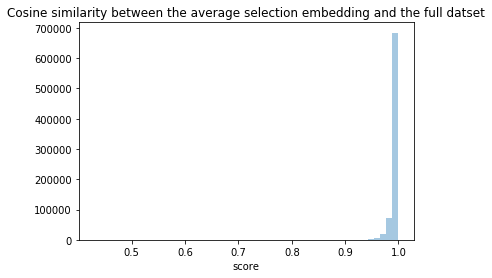

In [291]:
sns.distplot(cs_df.score, kde=False)
plt.title('Cosine similarity between the average selection embedding and the full datset');

**We could stop at this point and continue to loop through selecting new datapoints of interest and removing them from our full dataset, but for fun lets look at another way to do similarity search, using nmslib**

### Creating a nmslib Index
> Note: *As an alternative to Sci-kit Learn's cosine similarity function we can also use nmslib to calculate our similarity. Note this method is slower given our needs in this example, but its always fun to work with a new technology* 😀

Once we have all of our embeddings we can create our index with nmslib. This is the most time-consuming part of this process, it took 47minutes for the index to be created in this example, although there are other nmslib settings thatn can reduce this to ~15minutes.

We create an index for our entire dataset **only once**.  We create an index for the entire dataset because we will likely have multiple queries we do not want to re-create a new index each time as it will really slow down how fast we can identify and remove low quality data.

> Note: (This index will now include our sample datapoints, which are the same datapoints that we use in our query to the index. Therefore we will have to exclude these sample datapoints from our query result)

In [20]:
#hide
full_index = nmslib.init(method='hnsw', space='cosinesimil')
full_index.addDataPointBatch(full_emb.numpy())

# CREATE
# Creating an index for our 784k embeddings takes 47 minutes. we can trade off the quality of our index for a faster creation time if we'd like.
# 'post','M','efConstruction' parameter explanations here: https://github.com/nmslib/nmslib/blob/master/manual/methods.md
full_index.createIndex({'post': 2, 'M':80, 'efConstruction':1000}, print_progress=True)

# SAVE
full_index_nm='models/full_index.bin'
full_index.saveIndex(full_index_nm, save_data=True)

# LOAD
# To load the index again
# index = nmslib.init(method='hnsw', space='cosinesimil')
# index.loadIndex(full_index_nm, load_data=True)

In [ ]:
#hide
#NMS resources
# Code from https://github.com/benfred/bens-blog-code/blob/master/approximate_als/test_batch_queries.py
#         Associated blog post: http://www.benfrederickson.com/approximate-nearest-neighbours-for-recommender-systems/
#         nmslib parameter details here: https://github.com/nmslib/nmslib/blob/master/manual/methods.md

# Sample Class:
# class NMSLibIndex(object):
#     ''' 
#         Taken from https://github.com/benfred/bens-blog-code/blob/master/approximate_als/test_batch_queries.py
#         Associated blog post: http://www.benfrederickson.com/approximate-nearest-neighbours-for-recommender-systems/
#         nmslib parameter details here: https://github.com/nmslib/nmslib/blob/master/manual/methods.md
#     '''
#     def __init__(self, method, indexparams, queryparams):
#         self.method = method
#         self.indexparams = indexparams
#         self.queryparams = queryparams

#     def fit(self, data):
#         self.index = nmslib.init(method=self.method, space='cosinesimil')
#         self.index.addDataPointBatch(data)
#         self.index.createIndex(self.indexparams, print_progress=True)

#     def query_batch(self, queries, n=10):
#         return self.index.knnQueryBatch(queries, n)

# indices = {
#         'hnsw(post=0)': NMSLibIndex(method='hnsw',
#                                    indexparams=[
#                                        'M=32', 'post=0', 'efConstruction=800'],
#                                    queryparams=['ef=90']),
#         'hnsw(M=50post=2ef1500)': NMSLibIndex(method='hnsw',
#                                    indexparams=[
#                                        'M=50', 'post=2', 'efConstruction=1500'],
#                                    queryparams=['ef=500']),
#         'hnsw(post=2)': NMSLibIndex(method='hnsw',
#                                    indexparams=[
#                                        'M=32', 'post=2', 'efConstruction=800'],
#                                    queryparams=['ef=50'])}

### Querying the Index
Below are the sampled results from querying the full dataset, found through similarity search with an average embedding of the selection from the bokeh plot:

**Arabic**

In [184]:
#hide_input
show_similar(samp_embs, fin_selected_indxs, full_index)

1691 ids returned from query


,ga,en,noise_type
566807,قلعة فن البكسل ( pixels art ),طريقه عمل اطار منقط,na
571586,مواقع الارسال المجانى free sms ( 1 2),لا تستطيع الرد على المواضيع,na
571682,قلعة دروس الفيكتور illustrator و coreldraw,اللهم صلي وسلم على نبينا محمد,na
570557,مــحل الإقـامة: jordan - palestine,قلعة الصور الخاصة بالتصميم,na
566810,مــحل الإقـامة: jordan - palestine,مــحل الإقـامة: في الفوتوشوب,na


**Lighting**

In [187]:
#hide_input
show_similar(samp_embs, fin_selected_indxs, full_index)

1699 ids returned from query


,ga,en,noise_type
690718,an tsín bhí guangdong soilse linn snámha faoi stiúir monaróirí agus atá liostaithe anseo a fháil ag an soilsiú karnar.,the featured china guangdong 3x5 watts led-e27 manufacturers and listed here are sourced by the karnar lighting.,lighting
477330,foinse do gairdín lawn monaróirí ag soilsiú karnar zhongshan & leictreon mhonarcha.,source for high power led wall washer 144w led wall washer manufacturers at zhongshan karnar lighting & electron factory.,lighting
479274,an tsín bhí guangdong cumhacht ard-éadrom lawn faoi stiúir monaróirí agus atá liostaithe anseo a fháil ag an soilsiú karnar.,the featured china guangdong 3 watts led under ground lights round type manufacturers and listed here are sourced by the karnar lighting.,lighting
636797,an tsín bhí guangdong faoi stiúir tube monaróirí agus atá liostaithe anseo a fháil ag an soilsiú karnar.,the featured china guangdong led spot light flash lamp and fancy ball manufacturers and listed here are sourced by the karnar lighting.,lighting
692603,an tsín bhí guangdong faoi stiúir connectable soilse na nollag monaróirí agus atá liostaithe anseo a fháil ag an soilsiú karnar.,the featured china guangdong high-power led colorful 500w led wall washer manufacturers and listed here are sourced by the karnar lighting.,lighting


**Website Footer**

In [189]:
#hide_input
show_similar(samp_embs, fin_selected_indxs, full_index)

1825 ids returned from query


,ga,en,noise_type
696159,©2005-2010 karnardéan teagmháil linnnasc linnléarscáil an láithreáinlast modified: august 08 2016 02:43:19.,©2005-2010 karnarsambandlink okkurveftrélast modified: august 08 2016 04:06:45.,na
478396,©2005-2010 karnardéan teagmháil linnnasc linnléarscáil an láithreáinlast modified: july 31 2016 00:39:06.,©2005-2010 karnarcontact uslink ussite maplast modified: july 30 2016 22:04:01.,na
538977,©2005-2010 karnardéan teagmháil linnnasc linnléarscáil an láithreáinlast modified: july 14 2016 20:20:33.,©2005-2010 karnarcontact uslink ussite maplast modified: july 15 2016 01:50:20.,na
684675,©2005-2010 karnardéan teagmháil linnnasc linnléarscáil an láithreáinlast modified: august 08 2016 01:19:15.,©2005-2010 karnarcontactez-nousnous lierplan du sitelast modified: august 08 2016 03:54:30.,na
534904,©2005-2010 karnardéan teagmháil linnnasc linnléarscáil an láithreáinlast modified: july 31 2016 11:57:09.,©2005-2010 karnarcontact uslink ussite maplast modified: july 31 2016 09:46:30.,na


**Clothing and Jewelery**

In [181]:
#hide_input
show_similar(samp_embs, fin_selected_indxs, full_index)

1938 ids returned from query


,ga,en,noise_type
641483,home:: uaireadóirí hublot:: sraith fusion classic:: sraith 45mm fusion classic:: macasamhail hublot classic comhleá sraith faire 45mm 511.zx.1170,home:: hublot watches:: classic fusion series:: classic fusion 45mm series:: replica hublot classic fusion 45mm watch series 401.mx.0123.gr [da02],na
79453,"pandora bead óir ivy óir - €10.23 : jewelry pandora saor, pandoraaustraliabracelets.com","pandora gold bead ivy gold - $11.00 : cheap pandora jewelry, pandoraaustraliabracelets.com",na
615744,"clrip036a 925 sterling silver bán crystal ring - €28.83 : jewelry pandora saor , pandoraforyou.com","clrip036a 925 sterling silver white crystal ring - $31.00 : cheap pandora jewelry, pandoraforyou.com",na
67287,ard-chumhacht táirgí faoi stiúir > cumhacht ard-threoraithe colorful > product-list,led lighting > high-power led colorful > product-list lww-10 lww-10-108p lww-10-206p lww-8c-108p,lighting
635957,"prada málaí láimhe p - br4692 caife leathar : seaicéad spyder, pradahandbags.top","prada borse p - br4692 coffee leather : spyder giacca , pradahandbags.top",na


### Removal
If we like we can limit our removal to only very similar embeddings in the full dataset by only selecting the datapoints in the full dataset that are sufficiently close (lower score) to the average embedding, plotting the score distribution can help us decide on a suitable threshold

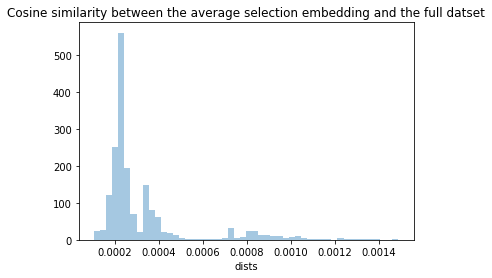

In [193]:
#hide_input
avg_np=calc_avg_emg(samp_embs, fin_selected_indxs)
avg_df=avg_query(full_index, avg_np, k=100000)
sns.distplot(avg_df.dists, kde=False)
plt.title('Cosine similarity between the average selection embedding and the full datset');

In [195]:
#hide
# # [ALTERNATIVE] Find similar embeddings for every individual selected datapoint
# #avg_np=np.expand_dims(avg_emb.numpy(), axis=0)
# selected_embs = samp_embs[fin_selected_indxs];selected_embs.size()

# # Translate our selected indices from the sample dataset into indices in the full dataset
# fin_selected_main_indxs = df.loc[samp.loc[fin_selected_indxs]['main_index']].index.values.tolist()

# full_index.setQueryTimeParams({'efSearch': 1000})

# neighbours_dict={}
# for k in [10,100,1000,10000]:
#     neighbours = full_index.knnQueryBatch(selected_embs.numpy(), k=k)   # returns for each query: (indices, distances)

#     inds_np_ls = [n[0] for n in neighbours]
#     dists_np_ls = [n[1] for n in neighbours]
#     tmp_inds = np.unique(np.concatenate(inds_np_ls).ravel())
#     tmp_dists = np.concatenate(dists_np_ls).ravel()
    
#     tmp_df = pd.DataFrame({'inds':np.concatenate(inds_np_ls).ravel(),
#                           'dists':np.concatenate(dists_np_ls).ravel()})
#     # drop the query indices
#     tmp_df=tmp_df.loc[~tmp_df.inds.isin(fin_selected_main_indxs)]
#     # drop duplicate indices (distances will be biassed towards early query values)
#     tmp_df.drop_duplicates(subset='inds', inplace=True, ignore_index=True)

# #     # Remove the query indices
# #     sorter = np.argsort(tmp_inds)
# #     to_remove=sorter[np.searchsorted(tmp_inds, fin_selected_main_indxs, sorter=sorter)]   # indices to remove
# #     fin_inds = np.delete(tmp_inds, to_remove)
    
#     neighbours_dict[f'k{k}_inds'] = tmp_df.inds.values #np.delete(tmp_inds, to_remove)
#     neighbours_dict[f'k{k}_dists'] = tmp_df.dists.values #np.delete(tmp_dists, to_remove)
#     print(f'{len(tmp_df.inds.values)} unique & similar indices returned for k = {k}')

In [194]:
#hide
# #hide_input
# # for k 10,100,1000
# colors=['skyblue', 'purple', 'black', 'teal']
# for i,k in enumerate([10,100,1000,10000]):
#     sns.distplot(neighbours_dict[f'k{k}_dists'] , color=colors[i], label=f'k={k}', kde=False)
# plt.legend()

## Summary
Hopefully this gives you a sense of how you can explore and clean up large, noisy text datasets. You can open this notebook on github and test it for your own text dataset. 

As always, I would love to hear your feedback, what could have been written better or clearer, you can find me on twitter: [@mcgenergy](www.twitter.com/mcgenergy)